# Test and Benchmark

In [1]:
using Revise
using VCFTools
using LinearAlgebra
using MendelImpute
using GeneticVariation
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using JLD2, FileIO, JLSO
using BenchmarkTools
using GroupSlices

┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1273


## Haplotyping timing varying number of haplotypes

In [15]:
Random.seed!(123)
ns = [100, 1000, 10000] # number of individuals
ps = [100, 1000, 10000]    # number of typed SNPs
ds = [100, 1000, 10000]  # number of reference haplotypes
for n in ns, p in ps, d in ds
    H = convert(Matrix{Float32}, rand(0:1, p, d))
    X = convert(Matrix{Float32}, rand(0:2, p, n))
    M = Transpose(H) * H
    for j in 1:d, i in 1:(j - 1) # off-diagonal
        M[i, j] = 2M[i, j] + M[i, i] + M[j, j]
    end
    for j in 1:d # diagonal
        M[j, j] *= 4
    end
    N = Transpose(X) * H
    for I in eachindex(N)
        N[I] *= 2
    end
    happair  = zeros(Int, n), zeros(Int, n)
    hapscore = zeros(eltype(N), n)
    t = @elapsed haplopair!(happair, hapscore, M, N)
    println("n = $n, p = $p, d = $d time = $t")
end

n = 100, p = 100, d = 100 time = 0.000456208
n = 100, p = 100, d = 1000 time = 0.038313572
n = 100, p = 100, d = 10000 time = 3.35376975
n = 100, p = 1000, d = 100 time = 0.0003795
n = 100, p = 1000, d = 1000 time = 0.038590982
n = 100, p = 1000, d = 10000 time = 3.374475433
n = 100, p = 10000, d = 100 time = 0.000484978
n = 100, p = 10000, d = 1000 time = 0.03808498
n = 100, p = 10000, d = 10000 time = 3.397484089
n = 1000, p = 100, d = 100 time = 0.004034878
n = 1000, p = 100, d = 1000 time = 0.3387065
n = 1000, p = 100, d = 10000 time = 34.682602842
n = 1000, p = 1000, d = 100 time = 0.004231036
n = 1000, p = 1000, d = 1000 time = 0.375277053
n = 1000, p = 1000, d = 10000 time = 36.049891365
n = 1000, p = 10000, d = 100 time = 0.003922379
n = 1000, p = 10000, d = 1000 time = 0.403318508
n = 1000, p = 10000, d = 10000 time = 35.155680319
n = 10000, p = 100, d = 100 time = 0.040836424
n = 10000, p = 100, d = 1000 time = 3.727595042
n = 10000, p = 100, d = 10000 time = 355.668273795
n 

# Try another way to compute optimal haplotypes

In [ ]:
Random.seed!(123)
ns = [100, 1000]         # number of individuals
ps = 100                 # number of typed SNPs
ds = [100, 1000, 10000]  # number of reference haplotypes
for n in ns, d in ds
    H = convert(Matrix{Float32}, rand(0:1, p, d))
    X = convert(Matrix{Float32}, rand(0:2, p, n))
    M = Transpose(H) * H
    for j in 1:d, i in 1:(j - 1) # off-diagonal
        M[i, j] = 2M[i, j] + M[i, i] + M[j, j]
    end
    for j in 1:d # diagonal
        M[j, j] *= 4
    end
    N = Transpose(X) * H
    for I in eachindex(N)
        N[I] *= 2
    end
    happair  = zeros(Int, n), zeros(Int, n)
    hapscore = zeros(eltype(N), n)
    t1 = @elapsed haplopair!(happair, hapscore, M, N)
    t2 = @elapsed haplopair2!(happair, hapscore, M, N)
    println("n = $n, p = $p, d = $d time = $t")
end

In [13]:
# note for future self: the UpperTriangular matrix seems to be allocating. Getting rid of it
# probably makes the resulting code the same as haplopair!
function haplopair2!(
    happairs::Tuple{AbstractVector, AbstractVector},
    hapmin::Vector{T},
    M::AbstractMatrix{T}, #upper triangular matrix
    N::AbstractMatrix{T},
    ons::AbstractVector{T},
    Nk::AbstractVector{T},
    storage::AbstractMatrix{T}
    ) where T <: Real

    n, d = size(N)
    fill!(hapmin, typemax(T))

    # for each individual k find minimum of M_ij - n_ki - n_kj
    for k in 1:n
        copyto!(Nk, @view(N[k, :]))
        storage .= M .- UpperTriangular(Nk .* ons') .- UpperTriangular(ons .* Nk')
        hapmin[k], index = findmin(storage)
        happairs[1][k], happairs[2][k] = index[1], index[2]
    end

    return nothing
end

haplopair2! (generic function with 1 method)

In [9]:
using Random, LinearAlgebra, MendelImpute

In [14]:
Random.seed!(123)
# ns = [100, 1000]         # number of individuals
# ps = 100                 # number of typed SNPs
# ds = [100, 1000, 10000]  # number of reference haplotypes

n = p = 100
d = 2000

H = convert(Matrix{Float32}, rand(0:1, p, d))
X = convert(Matrix{Float32}, rand(0:2, p, n))
M = Transpose(H) * H
for j in 1:d, i in 1:(j - 1) # off-diagonal
    M[i, j] = 2M[i, j] + M[i, i] + M[j, j]
end
for j in 1:d # diagonal
    M[j, j] *= 4
end
N = Transpose(X) * H
for I in eachindex(N)
    N[I] *= 2
end
happair1 = zeros(Int, n), zeros(Int, n)
happair2 = zeros(Int, n), zeros(Int, n)
hapscore1 = zeros(eltype(N), n)
hapscore2 = zeros(eltype(N), n)

ons = ones(Float32, d)
Nk = zeros(Float32, d)
storage = zeros(Float32, d, d)

@time haplopair!(happair1, hapscore1, M, N)
@time haplopair2!(happair2, hapscore2, M, N, ons, Nk, storage)

  0.143195 seconds (4 allocations: 160 bytes)
  3.116689 seconds (1.29 M allocations: 3.040 GiB, 9.63% gc time)


In [15]:
happair1

([534, 84, 490, 386, 99, 1602, 1221, 29, 681, 143  …  1129, 403, 155, 903, 136, 18, 470, 255, 267, 598], [1272, 459, 1285, 1004, 1390, 1738, 1551, 550, 1466, 755  …  1130, 930, 1786, 965, 1357, 1801, 1252, 1228, 1440, 1005])

In [16]:
happair2

([534, 84, 490, 386, 99, 1602, 1221, 29, 681, 143  …  1129, 403, 155, 903, 136, 18, 470, 255, 267, 598], [1272, 459, 1285, 1004, 1390, 1738, 1551, 550, 1466, 755  …  1130, 930, 1786, 965, 1357, 1801, 1252, 1228, 1440, 1005])

# Try using Distance package

In [77]:
Random.seed!(123)

n = 100
p = 100
d = 1000

H = bitrand(p, d)
X = rand(UInt8, p, n);

In [78]:
@time happairs, hapscore = haplopair(X, H)

  0.058263 seconds (19 allocations: 4.619 MiB)


(([860, 340, 340, 340, 340, 197, 340, 340, 340, 340  …  340, 340, 229, 340, 193, 340, 583, 197, 340, 340], [860, 340, 728, 340, 340, 197, 765, 340, 340, 340  …  340, 340, 229, 340, 845, 340, 583, 197, 340, 340]), Float32[2.208377e6, 2.084862e6, 2.254124e6, 1.995901e6, 2.365823e6, 2.214043e6, 1.976373e6, 2.180052e6, 2.245112e6, 1.936614e6  …  1.906484e6, 1.976561e6, 1.964542e6, 2.255616e6, 2.217225e6, 2.072651e6, 2.211937e6, 2.235235e6, 2.138406e6, 2.203285e6])

In [79]:
@time happairs, hapscore = haplopair_thin(X, H, keep = 1000)

  0.241185 seconds (100.43 k allocations: 9.984 MiB)


(([860, 340, 728, 340, 340, 197, 340, 340, 340, 340  …  340, 340, 229, 340, 193, 340, 583, 197, 340, 340], [860, 340, 340, 340, 340, 197, 765, 340, 340, 340  …  340, 340, 229, 340, 845, 340, 583, 197, 340, 340]), Float32[2.208377e6, 2.084862e6, 2.254124e6, 1.995901e6, 2.365823e6, 2.214043e6, 1.976373e6, 2.180052e6, 2.245112e6, 1.936614e6  …  1.906484e6, 1.976561e6, 1.964542e6, 2.255616e6, 2.217225e6, 2.072651e6, 2.211937e6, 2.235235e6, 2.138406e6, 2.203285e6])

In [80]:
@time happairs, hapscore = haplopair_thin(X, H, keep = 100)

  0.035336 seconds (100.43 k allocations: 5.860 MiB)


(([16, 133, 16, 79, 4, 133, 98, 229, 79, 340  …  16, 4, 79, 143, 164, 16, 133, 54, 193, 79], [16, 133, 16, 79, 4, 169, 98, 229, 79, 340  …  16, 4, 79, 143, 164, 16, 133, 54, 193, 79]), Float32[2.211473e6, 2.089394e6, 2.258094e6, 1.999909e6, 2.369783e6, 2.218648e6, 1.980113e6, 2.181852e6, 2.2493e6, 1.936614e6  …  1.90824e6, 1.979109e6, 1.969238e6, 2.260148e6, 2.218616e6, 2.077211e6, 2.215713e6, 2.238991e6, 2.140286e6, 2.206365e6])

In [81]:
linsp = 100:500:10000
t1 = zeros(length(linsp))
t2 = zeros(length(linsp))
n = 100
p = 100

Random.seed!(2020)
for (i, d) in enumerate(linsp)
    H = bitrand(p, d)
    X = rand(UInt8, p, n);
    t1[i] = @elapsed haplopair(X, H)
    t2[i] = @elapsed haplopair_thin(X, H, keep = 100)
end

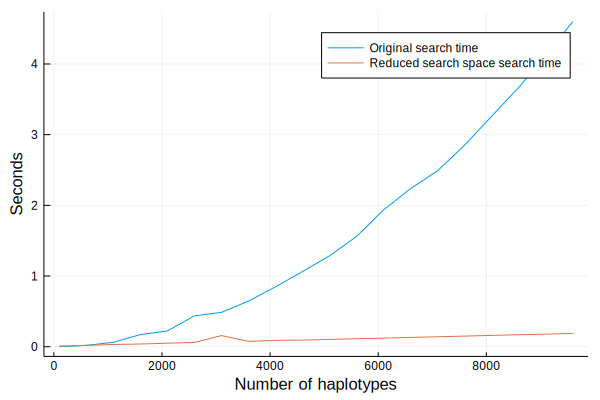

In [90]:
using Plots
x = plot(linsp, t1, label="Original search time", ylabel="Seconds", xlabel="Number of haplotypes")
plot!(x, linsp, t2, label="Reduced search space search time")

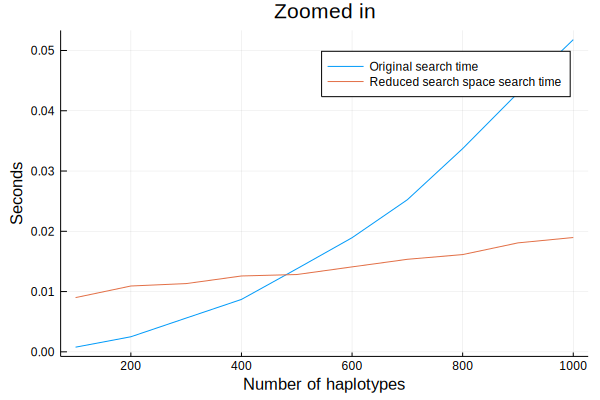

In [94]:
# ZOOM in

linsp = 100:100:1000
t1 = zeros(length(linsp))
t2 = zeros(length(linsp))
n = 100
p = 100

Random.seed!(2020)
for (i, d) in enumerate(linsp)
    H = bitrand(p, d)
    X = rand(UInt8, p, n);
    t1[i] = @elapsed haplopair(X, H)
    t2[i] = @elapsed haplopair_thin(X, H, keep = 100)
end
x = plot(linsp, t1, title = "Zoomed in", label="Original search time", 
    ylabel="Seconds", xlabel="Number of haplotypes")
plot!(x, linsp, t2, label="Reduced search space search time")

# Benchmark original code

In [14]:
Random.seed!(123)

n = 100
p = 100
d = 1000

M = rand(Float32, d, d)
N = rand(Float32, n, d)
H = convert(Matrix{Float32}, rand(0:1, p, d))
X = convert(Matrix{Float32}, rand(0:2, p, n))
happair1 = zeros(Int, n)
happair2 = zeros(Int, n)
hapscore = zeros(Float32, n)

@btime haplopair!(happair1, happair2, hapscore, M, N) setup=(M=rand(Float32, d, d), N=rand(Float32, n, d))

  29.677 ms (0 allocations: 0 bytes)


In [12]:
Random.seed!(123)

n = 100
p = 100
d = 1000

M = rand(Float32, d, d)
N = rand(Float32, n, d)
H = convert(Matrix{Float32}, rand(0:1, p, d))
X = convert(Matrix{Float32}, rand(0:2, p, n))
happairs = zeros(Int, n), zeros(Int, n)
hapscore = zeros(Float32, n)

@btime haplopair!(happairs, hapscore, M, N) setup=(M=rand(Float32, d, d), N=rand(Float32, n, d))

  35.057 ms (0 allocations: 0 bytes)
